In [47]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,RepeatedKFold,GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

In [48]:
data = pd.read_csv("insurance[1].csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [49]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


In [50]:
print(data.isna().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


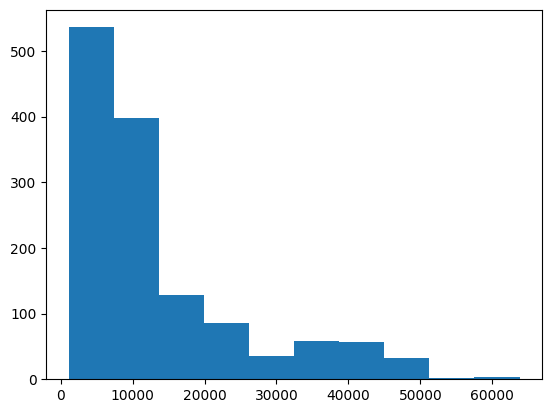

In [51]:
plt.hist(data['charges'])
plt.show()

Heavily skewed to the right, data is concentrated near 0 with many high outliers, look at a boxplot

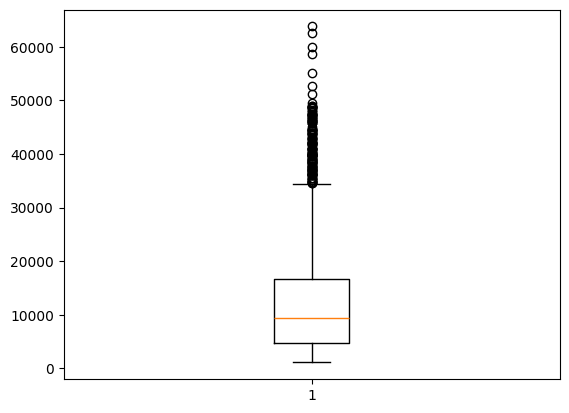

In [52]:
plt.boxplot(data['charges'])
plt.show()

We can see that our variable is highly skewed. We can correct for this issue by taking the log of our target variable.

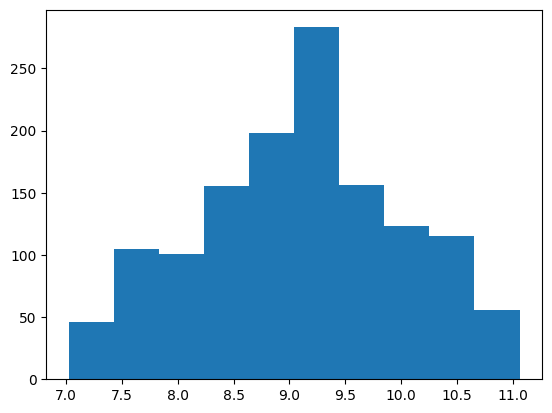

In [53]:
target = np.log(data['charges'])
plt.hist(target)
plt.show()

In [54]:
data['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

## Encoding Variables

In [55]:
# Encoding smoker or
data[["smoker"]] = OrdinalEncoder().fit_transform(data[["smoker"]])
print(data["smoker"].value_counts()) #Looks good

smoker
0.0    1064
1.0     274
Name: count, dtype: int64


In [56]:
# Label encoding(no order)
data["sex"] = LabelEncoder().fit_transform(data["sex"])
print(data["sex"].value_counts())

sex
1    676
0    662
Name: count, dtype: int64


In [57]:
# Encoding region
data["region"] = LabelEncoder().fit_transform(data["region"])
print(data["region"].value_counts())

region
2    364
3    325
1    325
0    324
Name: count, dtype: int64


## Splitting, training model

In [58]:
# Train/tune/test split
X = data.drop(columns='charges')
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=13)
X_tune, X_test, y_tune, y_test = train_test_split(X_test,y_test,  train_size = 0.50, random_state=72)

## Creating the kfold object for cross validation

In [59]:
kf = RepeatedKFold(n_splits=10, n_repeats =5, random_state=10)

## Creating the scoring metric and choosing a hyperparameter

In [60]:
scoring = ['neg_mean_squared_error','r2','neg_mean_absolute_error']

param = {'min_samples_leaf': [10,12,14,16,18,20,22,24,26,28,30]}

In [29]:
best = model.best_estimator_
print(best) #depth of 5, good

DecisionTreeRegressor(max_depth=4, random_state=30)


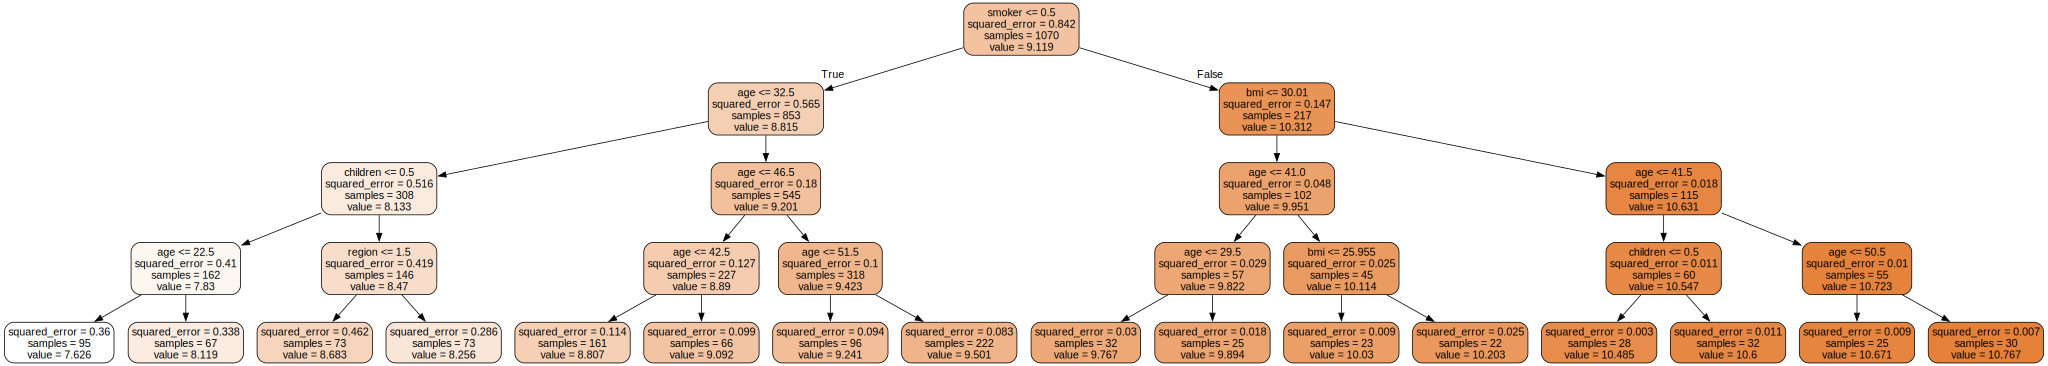

In [38]:
dot_data = export_graphviz(best, out_file=None,
               feature_names=X.columns, # feature names from dataset
               filled=True, 
               rounded=True, 
               class_names=['ave', 'excellent']) # classification labels 

graph = graphviz.Source(dot_data)
graph=graphviz.Source(dot_data)
graph

In [39]:
print(model.cv_results_)

{'mean_fit_time': array([0.00416971, 0.0047097 , 0.00541553, 0.00674993, 0.00711475]), 'std_fit_time': array([0.0008293 , 0.00083763, 0.00098462, 0.00177857, 0.00106732]), 'mean_score_time': array([0.00333589, 0.00328555, 0.00314978, 0.00348246, 0.00345846]), 'std_score_time': array([0.00097557, 0.00070396, 0.0005708 , 0.00108707, 0.00086195]), 'param_max_depth': masked_array(data=[2, 4, 6, 8, 10],
             mask=[False, False, False, False, False],
       fill_value=999999), 'params': [{'max_depth': 2}, {'max_depth': 4}, {'max_depth': 6}, {'max_depth': 8}, {'max_depth': 10}], 'split0_test_neg_mean_squared_error': array([-0.26285005, -0.16803042, -0.30429862, -0.36013438, -0.44879454]), 'split1_test_neg_mean_squared_error': array([-0.34383884, -0.26077774, -0.33430785, -0.40966895, -0.51085864]), 'split2_test_neg_mean_squared_error': array([-0.29067904, -0.21620519, -0.2589399 , -0.33670906, -0.32779206]), 'split3_test_neg_mean_squared_error': array([-0.23835855, -0.20383781, -0.202

In [45]:
#Let's extract these scores based on depth!

#Scores: 

#Have negative mean squared error so need to take absolute value and square root to convert to root mean squared error
mean_sq_err = np.sqrt(abs(model.cv_results_['mean_test_neg_mean_squared_error']))
#nothing needs to be done for r2, it is the same
r2= model.cv_results_['mean_test_r2']
#Have negative mean absolute error so need to take absolute value
mae= abs(model.cv_results_['mean_test_neg_mean_absolute_error'])

#Get standard deviations as well...
SDmse =  model.cv_results_['std_test_neg_mean_squared_error']
SDr2= model.cv_results_['std_test_r2']
SDmae= model.cv_results_['std_test_neg_mean_absolute_error']

#Parameter:
depth= np.unique(model.cv_results_['param_max_depth']).data

#Build DataFrame:
final_model = pd.DataFrame(list(zip(depth, mean_sq_err, r2,mae, SDmse,SDr2,SDmae)),
               columns =['depth','rmse','r2','mae',"rmseSD",'r2SD','maeSD'])

#Let's take a look
final_model

,depth,rmse,r2,mae,rmseSD,r2SD,maeSD
0,2,0.507292,0.689194,0.354316,0.046029,0.060200,0.026245
1,4,0.412449,0.793904,0.242881,0.043180,0.057838,0.025607
2,6,0.436731,0.770180,0.242724,0.058078,0.068838,0.029416
3,8,0.489607,0.711630,0.252634,0.078478,0.091933,0.036769
4,10,0.538866,0.653100,0.261885,0.096679,0.098897,0.042353


In [43]:
## Building the regression tree object

          importance
smoker      0.527637
age         0.385718
children    0.043107
bmi         0.034494
region      0.009043
sex         0.000000


In [61]:
reg=DecisionTreeRegressor(random_state=10)

## Creating a grid search object and fitting the model to the training data

In [62]:
search = GridSearchCV(reg, param, scoring=scoring, n_jobs=-1, cv=kf, refit='neg_mean_squared_error')

model = search.fit(X_train, y_train)

## Looking at the results

In [63]:
mean_sq_err = abs(model.cv_results_['mean_test_neg_mean_squared_error'])
r2= model.cv_results_['mean_test_r2']
min_leaf = model.cv_results_['param_min_samples_leaf'].data

final_model = pd.DataFrame(list(zip(min_leaf, mean_sq_err, r2)),columns =['min_leaf', 'mse','r2'])

print("Best Parameters:", model.best_params_)
print("Best Score (Mean Squared Error):", np.abs(model.best_score_))


final_model

Best Parameters: {'min_samples_leaf': 24}
Best Score (Mean Squared Error): 0.16634994323106184


,min_leaf,mse,r2
0,10,0.177376,0.785761
1,12,0.170462,0.794101
2,14,0.171957,0.792154
3,16,0.170574,0.793886
4,18,0.167555,0.797446
5,20,0.167054,0.797988
6,22,0.166965,0.798049
7,24,0.166350,0.798859
8,26,0.166494,0.798642
9,28,0.166895,0.798350


## Finding the most important variables

In [64]:
varimp = pd.DataFrame(model.best_estimator_.feature_importances_, index = X.columns, columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

          importance
smoker      0.515095
age         0.385704
children    0.048917
bmi         0.034227
region      0.012542
sex         0.003514
